# Credit Risk Default - Model Version 2 - "In Progress"

__Default_payment: 1 = Yes (defaulted), 0 = No (did not default)__




# Model Version 2 Improvements



1. use SMOTETomek with a 0.5 sampling straegy but alone isn't enough when precision remains low, like in model version 1 results.

2. Combine SMOTETomek + class weighting + threshold tuning:

3. Fit SMOTETomek on training set inside the pipeline.

4. Train model with class_weight='balanced' or scale_pos_weight.

5. setting a custom threshold to balance precision and recall by evaluating multiple F1 thresholds start with threshold test range of (0.3 - 0.5)

    * If false negatives are worse (e.g., fraud), choose lower threshold → higher recall

    * If false positives are costly, choose higher threshold → higher precision
  
__When to Lower or Raise the Threshold:__

Catch more positive cases = Increase recall	Lower (< 0.5)
Avoid false alarms = Increase precision Higher (> 0.5)
Balanced F1-score =	Choose based on curve and then tune




# Feature Engineer - add new predictive measures 

The recent payment ratio is an important financial feature that can improve 
the performance of credit default prediction models in machine learning. 

Here's how they contribute:

## 1. Recent Payment Ratio

Definition:

The ratio of recent payments made by a borrower to their total recent billing or due amount over the last 6 months.

Calculation: __recent_payment_ratio = total_recent_payment_amount / total_recent_bill_amount__


## 2. Average Payment & bill Amount

Definition:

Detects variability and consistency in payments. Sharp drops may suggest financial strain.

Calculation: 

__mean(payment_amount over last 6 months)__

__mean(bill_amount over last 6 months)__



In [1]:
#Libaries and dependencies
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.sparse import issparse
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score
import joblib
from sqlalchemy import create_engine
from collections import Counter
from sklearn.metrics import precision_score, recall_score, f1_score
from imblearn.combine import SMOTETomek

In [2]:
db_config = {
    "user": "postgres",
    "password": "password",
    "host": "localhost",
    "port": 5432,
    "database": "credit_etl"
}

engine = create_engine(f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}")

In [3]:
#load data from db to dataframe
query = "select * from raw.raw_customer_default_payment"

credit_data = pd.read_sql(query, engine)
credit_data

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


## Create a customer transformer to calculate new payment ratios

In [4]:
class FeatureTransformer(BaseEstimator, TransformerMixin):
    def fit(self, x, y='none'):
        return self #nothing to learn so return self
        
    def transform(self, x):
        if not isinstance(x, pd.DataFrame):
            raise ValueError("input x must be dataframe")
            
        #take a copy fro transform and convert payments to numpy values   
        x = x.copy()
        recent_payments_values = x[['pay_amt1','pay_amt2','pay_amt3','pay_amt4','pay_amt5','pay_amt6']].values
        recent_bill_values = x[['bill_amt1','bill_amt2','bill_amt3','bill_amt4', 'bill_amt5','bill_amt6']].values
        
        #sum payments and bill amounts for previous 6 month periods
        recent_payments = np.nan_to_num(recent_payments_values.sum(axis=1), nan=0)
        recent_bills = np.nan_to_num(recent_bill_values.sum(axis=1), nan=0)
        recent_payment_avg = np.nan_to_num(recent_payments_values.mean(axis=1), nan=0)
        recent_bill_avg = np.nan_to_num(recent_bill_values.mean(axis=1), nan=0)
        
        # calculate pay recent ratio, handle infinite numbers and NaN for division 
        x['recent_payment_ratio'] = np.divide(recent_payments, recent_bills, where=recent_bills != 0, out=np.zeros_like(recent_payments, dtype=float))
        x['recent_payment_ratio'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)
        x['avg_payment_amt_6mts'] = recent_payment_avg
        x['avg_bill_amt_6mts'] = recent_bill_avg
        
        return x

## Split the data into test set 20%, training set 80%

In [5]:
y = credit_data['default_payment_next_month']
x = credit_data.drop(columns=['default_payment_next_month', 'id'])
#train test split 
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y)

## Train Credit XGBoost model version 2

In [14]:
# Calculate the scale weight ratio for imbalanced classes
from collections import Counter
counter = Counter(y_train) 

scale_weight_ratio = counter[0] / counter[1]


#define the column transformer with OneHotEncoder
preprocessor = ColumnTransformer(transformers=[
    #('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
    ('num', StandardScaler(), slice(0, x.shape[1]))
])

#resampling technique for imbalanced class 1
smote = SMOTETomek(random_state=42, sampling_strategy=0.5)

#Cross validation 10 folds which are stratified
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

#Pipeline that combines custom transformers and model for modularity & performance
pipeline = Pipeline(steps=[
    ('feature_transformer', FeatureTransformer()),
    ('preprocess', preprocessor),
    ('smote',SMOTETomek(random_state=42)),#SMOTE to handle class imbalance
    #('selection', SelectKBest(score_func = f_classif, k=25)),
    ('clf', XGBClassifier(eval_metric='auc', random_state=42, scale_pos_weight=scale_weight_ratio))
])


# Define the scoring method for cross-validation (AUC in this case)
scoring = make_scorer(roc_auc_score)

param_grid = {
    'clf__n_estimators': [50, 100, 200, 300],
    'clf__max_depth': [4,8],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__subsample': [0.9],
    'clf__reg_alpha': [0, 0.3, 0.7],  # L1 regularization
    'clf__reg_lambda': [1, 10]      # L2 regularization
}

#Grid search for optimizing tuning of hyperparmeters
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid,
                           scoring=scoring, cv=cv, verbose=1, n_jobs=-1)

grid_search.fit(x_train, y_train)  # optional, suppress per-iteration output

best_params = grid_search.best_params_
print('Best Params:', best_params)
print("Best AUC:", grid_search.best_score_)

#use predict proba on test data
credit_best_model = grid_search.best_estimator_
y_pred_proba = credit_best_model.predict_proba(x_test)[:,1]

# Assign a F1 threshold value to tune 
threshold = 0.35
y_pred_custom = (y_pred_proba >= threshold).astype(int)

print("Precision:", precision_score(y_test, y_pred_custom))
print("Recall:",recall_score(y_test, y_pred_custom))
print("F1-score:", f1_score(y_test, y_pred_custom))


test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC on test set: {test_auc:.4f}")

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
Best Params: {'clf__learning_rate': 0.1, 'clf__max_depth': 8, 'clf__n_estimators': 200, 'clf__reg_alpha': 0.7, 'clf__reg_lambda': 10, 'clf__subsample': 0.9}
Best AUC: 0.6950061315660988
Precision: 0.3291384317521781
Recall: 0.7686510926902789
F1-score: 0.4609127880704925
AUC on test set: 0.7549


In [18]:
joblib.dump(credit_best_model, 'credit_best_model_v2.pkl')

['credit_best_model_v2.pkl']

# Model Evaluation - Precision & Recall

__OBJECTIVE__

To minimize false positives, avoid predicting someone will default (1) when they won’t (0).

Improve precision for class 1 to catch more defaulters we set the Set a lower classification threshold of 0.35 to increase recall.

* Improve specificity (true negative rate)

* Increase threshold to be more cautious about predicting a default.

* Increases recall (more positives are caught),

* Decrease precision (more false positives)

__RESULTS__

So by lowering the threshold to __0.35__ will help catch more defaulters (increase recall for class 1). 

This result helps in high-risk domains (like fraud, or credit default), where missing a positive is more costly than a few extra false alarms.
Optimizing for class 1 (defaulters) is usually more important: It’s costly to misclassify a defaulter as a non-defaulter (false negative).

When examinaing the classification report below we see by adjusting the classification threshold to __0.35__, we significantly improved our ability to identify defaulters __(recall for class 1 increased to 76.9%).__ 
This comes at the expense of precision and recall at __55%__ for non-defaulters (class 0), but such a trade-off is acceptable in credit risk modeling, where failing to identify a 
defaulter is more costly than incorrectly flagging a non-defaulter.


# Classification Report

In [15]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_custom, digits=4))

              precision    recall  f1-score   support

           0     0.8942    0.5551    0.6850      4673
           1     0.3291    0.7687    0.4609      1327

    accuracy                         0.6023      6000
   macro avg     0.6117    0.6619    0.5729      6000
weighted avg     0.7692    0.6023    0.6354      6000



# F1 Precision vs Threshold Analysis

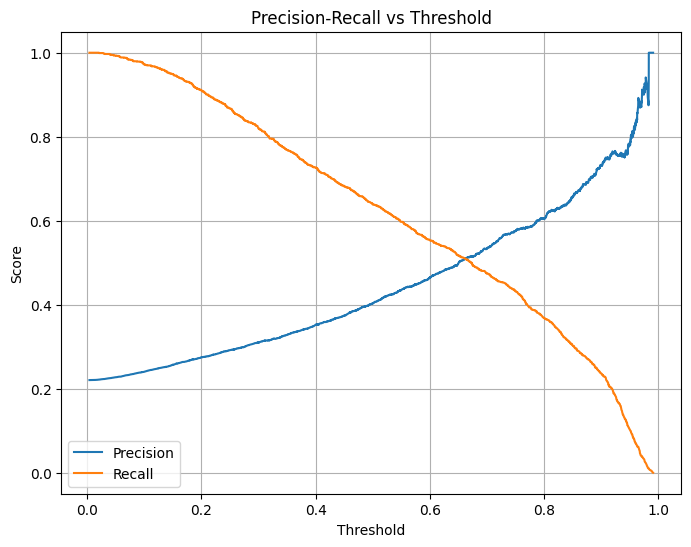

In [16]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_proba = credit_best_model.predict_proba(x_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import mlflow.sklearn

mlflow.set_tracking_uri("http://localhost:5000")

#log model with flow
with mlflow.start_run() as run:
    mlflow.sklearn.log_model('credit_best_model_v1.pkl', artifact_path= 'credit_best_model_v1')
    #print(f"Run ID: {run.info.run_id}")

#register model

result = mlflow.register_model(
    model_uri=f"runs:/{run.info.run_id}/credit_best_model_V1",
    name="credit_score_model"
)